In [37]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

import matplotlib.colors as mcolors
from matplotlib import rcParams
%matplotlib notebook

import os
#-----
from torch.utils.tensorboard import SummaryWriter

In [38]:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# Split data on grid

In [3]:
path = '../../Data_Gaussian_64size/data0'  # Directory where are saving our data

In [4]:
def split_data(path):
    waveA = np.empty((200,32), dtype=np.complex_)
    waveB = np.empty((200,32), dtype=np.complex_)

    potA = np.empty((200,32), np.float32)
    potB = np.empty((200,32), np.float32)
    
    os.makedirs('./'+path+'A/Wavepacket')
    os.makedirs('./'+path+'A/Potential')
    
    os.makedirs('./'+path+'B/Wavepacket')
    os.makedirs('./'+path+'B/Potential')
    
    
    for t in range(200):
    
        wave = np.load(path+'/Wavepacket/'+str(t)+'-wave.npy')
        pot = np.load(path+'/Potential/'+str(t)+'-potential.npy')
    
        for i in range(32):
        
            waveA[t][i] = wave[i*2]
            potA[t][i] = pot[i*2]
        
            waveB[t][i] = wave[i*2+1]
            potB[t][i] = pot[i*2+1]
        
                    
        with open(os.path.join('./'+path+'A/Wavepacket', str(t)+'-wave.npy'), 'wb') as f:
                    np.save(f, waveA[t])
        with open(os.path.join('./'+path+'A/Potential', str(t)+'-potential.npy'), 'wb') as f:
                    np.save(f, potA[t])
                
        with open(os.path.join('./'+path+'B/Wavepacket', str(t)+'-wave.npy'), 'wb') as f:
                    np.save(f, waveB[t])
        with open(os.path.join('./'+path+'B/Potential', str(t)+'-potential.npy'), 'wb') as f:
                    np.save(f, potB[t])
                
        
    return
    

In [5]:
split_data(path)

# Predictions

In [6]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, sequence_len, total_data = 8000*200, transform=True, traj=200):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.sequence_len = sequence_len
        self.total_data = total_data//sequence_len
        self.traj = traj
        
        self.denom = self.traj//self.sequence_len  # 0-199=200 data per file / 5 = seq len 
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 200 data by file (from 0 to 199), 1000 files(from 0 to 999), total data: 200*100 = 200000
        
        if index > total_data - 1:
            print("Error, this data does not exist")
        else:
            index_data = index
            
            X = np.empty((self.sequence_len,96), np.float32)
            y = np.empty((self.sequence_len,64), np.float32)
            
            for i in range(self.sequence_len-1):
                # Input data: Wavepacket real and imaginary part + Potential at time t
                x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).real
                x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(i)+'-wave.npy')).imag
                x_p = np.load(self.data+str(index_data)+'/Potential/'+str(i)+'-potential.npy')
                
                X[i] = np.concatenate((x_r, x_i, x_p))  # flat array form
                
                # Output data: Wavepacket real and imaginary part at time t+1
                y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).real
                y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(i+1)+'-wave.npy')).imag
        
                y[i] = np.concatenate((y_r, y_i))  # flat array form
                
            '''  
            # Output data: Wavepacket real and imaginary part at time t+sequence len
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+self.sequence_len)+'-wave.npy')).imag
        
            y = np.concatenate((y_r, y_i))  # flat array form
            '''  
        
            if self.transform:
                X = torch.from_numpy(X)
                y = torch.from_numpy(y)
        
            return X, y#[None, :]
    
    def __len__(self):
        
        
        return self.total_data

In [7]:
pathA = '../../Data_Gaussian_64size/dataA'  # Directory where are saving our data
pathB = '../../Data_Gaussian_64size/dataB'
seq_len = 200  # How many time stamps

In [8]:
datasetA = Propagator_Dataset(data=pathA, targets=pathA, transform=True, sequence_len=seq_len, total_data=1*200)
datasetB = Propagator_Dataset(data=pathB, targets=pathB, transform=True, sequence_len=seq_len, total_data=1*200)

In [9]:
len(datasetA)

1

In [10]:
batch_size = 1

In [11]:
test_loaderA = DataLoader(datasetA, batch_size=batch_size)
test_loaderB = DataLoader(datasetB, batch_size=batch_size)

In [12]:
for X, y in test_loaderA:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Train data:
Shape of X in train loader: torch.Size([1, 200, 96])
Shape of y in train loader: torch.Size([1, 200, 64])
Batch size: 1


## LSTM model

In [13]:
device = 'cpu'

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_output = num_output  # number of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        
        #self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1

        #self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, num_output) #fully connected last layer
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1,self.hidden_size) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) #first Dense
        #out = self.relu(output) #relu
        out = self.fc(output) #Final Output
        return out

In [15]:
model = torch.load('../Models/06-08-23_290EPOCHS.pth')

# Predictions

In [39]:
def prediction(test_load):
    
    for X,y in test_load:
        X, y = X.to(device), y.to(device)
    
        Entrada = X
    
        Salida = y

        with torch.inference_mode():
            Prediccion = model(X.float())
        break
    
    return Entrada, Salida, Prediccion

In [17]:
def group_grid(test_loaderA, test_loaderB, batch):
    
    Entrada = np.empty((200,192), np.float32)
    Salida = np.empty((200,128), np.float32)
    Prediccion = np.empty((200,128), np.float32)
    
    EntradaA, SalidaA, PrediccionA = prediction(test_loaderA)
    EntradaB, SalidaB, PrediccionB = prediction(test_loaderB)
    
    for t in range(200):
        
        for r in range(96):
            Entrada[t][2*r] = EntradaA[batch, t, r]
            Entrada[t][2*r+1] = EntradaB[batch, t, r]
            
            
        for s in range(64):
            Salida[t][2*s] = SalidaA[batch, t, s]
            Salida[t][2*s+1] = SalidaB[batch, t, s]
           
            
            Prediccion[t][2*s] = PrediccionA[batch, t, s]
            Prediccion[t][2*s+1] = PrediccionB[batch, t, s]
            
    
    return Entrada, Salida, Prediccion
        
    
    

In [18]:
Entrada, Salida, Prediccion = group_grid(test_loaderA, test_loaderB, 0)

In [19]:
type(Entrada)

numpy.ndarray

In [56]:
r_n = np.linspace(-1.5,1.5,64)

time = int(95)

In_real_vis = Entrada[time,0:64]
In_imag_vis = Entrada[time,64:128]
Pote = Entrada[time,128:192]

Ou_real_vis = Salida[time,0:64]
Ou_imag_vis = Salida[time,64:128]
Pote_next = Entrada[time+1,128:192]

Pred_real_vis = Prediccion[time,0:64]
Pred_imag_vis = Prediccion[time,64:128]

<IPython.core.display.Javascript object>


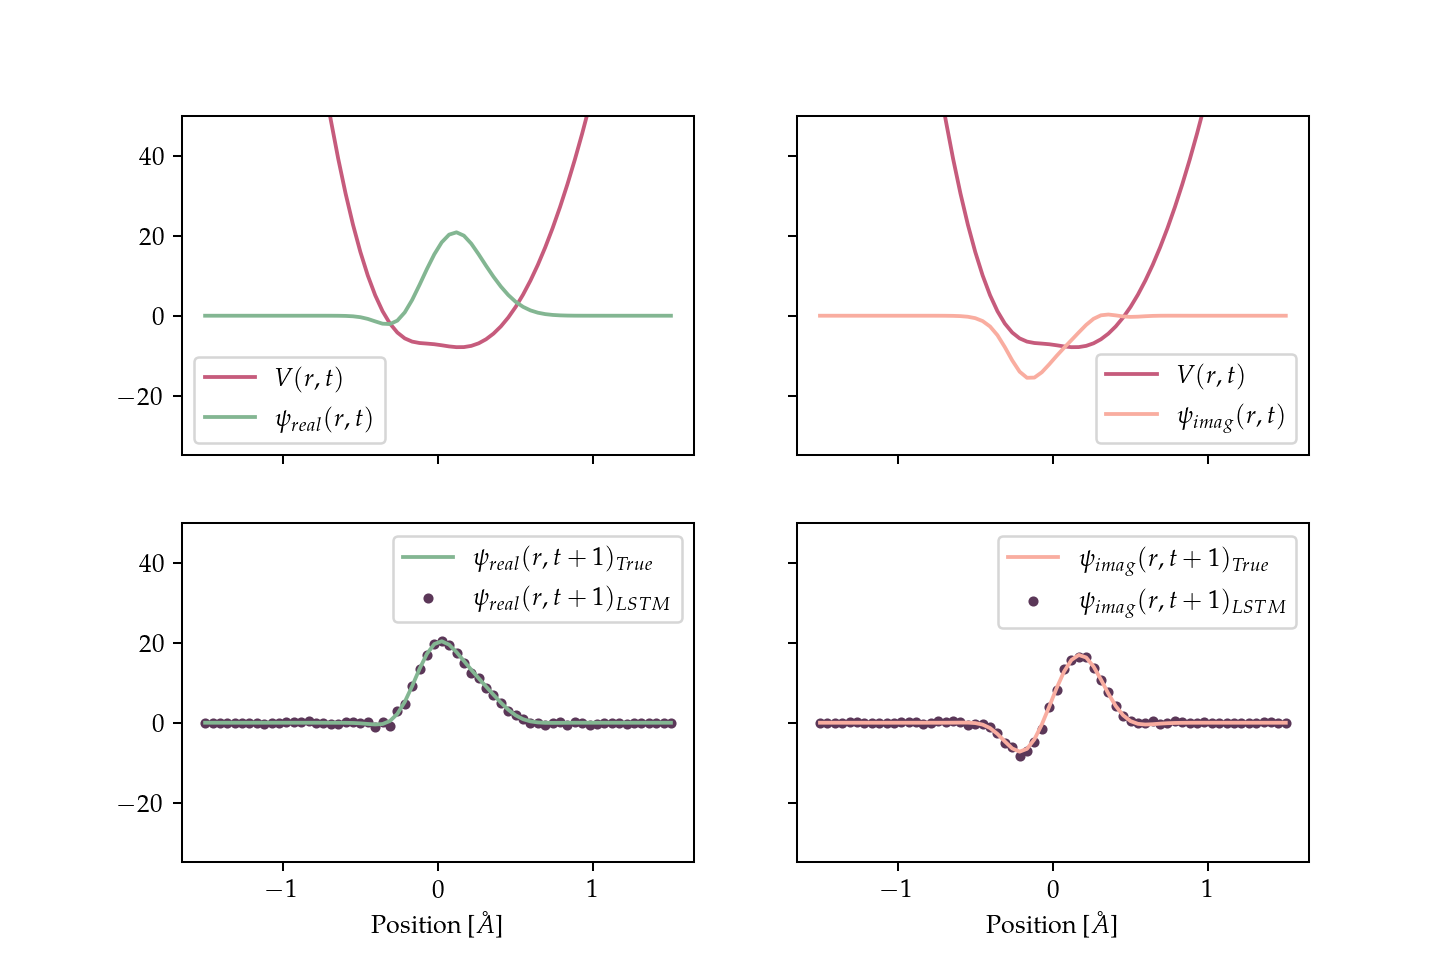

In [57]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
 

plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()
plt.savefig('/home/jessica/Tesis/img/tesis/model/1step64size2.png', dpi=700)

# Density

In [61]:
#------------- t=0
In_real_vis0 = Entrada[0,0:64]
In_imag_vis0 = Entrada[0,64:128]
In_dens0 = (np.abs(np.vectorize(complex)(In_real_vis0,In_imag_vis0)))**2

Pote0 = Entrada[0,128:192]


#------------ t=40 fs
Ou_real_vis0 = Salida[40,0:64]
Ou_imag_vis0 = Salida[40,64:128]
Ou_dens0 = (np.abs(np.vectorize(complex)(Ou_real_vis0,Ou_imag_vis0)))**2
      
Pred_real_vis0 = Prediccion[40,0:64]
Pred_imag_vis0 = Prediccion[40,64:128]
Pred_dens0 = (np.abs(np.vectorize(complex)(Pred_real_vis0,Pred_imag_vis0)))**2

#-------------- t=80 fs
In_real_vis1 = Entrada[80,0:64]
In_imag_vis1 = Entrada[80,64:128]
Pote1 = Entrada[80,128:192]

Ou_real_vis1 = Salida[80,0:64]
Ou_imag_vis1 = Salida[80,64:128]
Ou_dens1 = (np.abs(np.vectorize(complex)(Ou_real_vis1,Ou_imag_vis1)))**2

Pred_real_vis1 = Prediccion[80,0:64]
Pred_imag_vis1 = Prediccion[80,64:128]
Pred_dens1 = (np.abs(np.vectorize(complex)(Pred_real_vis1,Pred_imag_vis1)))**2

#-------------- t=120 fs
In_real_vis2 = Entrada[120,0:64]
In_imag_vis2 = Entrada[120,64:128]
Pote2 = Entrada[120,128:192]

Ou_real_vis2 = Salida[120,0:64]
Ou_imag_vis2 = Salida[120,64:128]
Ou_dens2 = (np.abs(np.vectorize(complex)(Ou_real_vis2,Ou_imag_vis2)))**2

Pred_real_vis2 = Prediccion[120,0:64]
Pred_imag_vis2 = Prediccion[120,64:128]
Pred_dens2 = (np.abs(np.vectorize(complex)(Pred_real_vis2,Pred_imag_vis2)))**2

#-------------- t=160 fs
In_real_vis3 = Entrada[160,0:64]
In_imag_vis3 = Entrada[160,64:128]
Pote3 = Entrada[160,128:192]

Ou_real_vis3 = Salida[160,0:64]
Ou_imag_vis3 = Salida[160,64:128]
Ou_dens3 = (np.abs(np.vectorize(complex)(Ou_real_vis3,Ou_imag_vis3)))**2

Pred_real_vis3 = Prediccion[160,0:64]
Pred_imag_vis3 = Prediccion[160,64:128]
Pred_dens3 = (np.abs(np.vectorize(complex)(Pred_real_vis3,Pred_imag_vis3)))**2

#-------------- t=200 fs
In_real_vis4 = Entrada[198,0:64]
In_imag_vis4 = Entrada[198,64:128]
Pote4 = Entrada[198,128:192]

Ou_real_vis4 = Salida[198,0:64]
Ou_imag_vis4 = Salida[198,64:128]
Ou_dens4 = (np.abs(np.vectorize(complex)(Ou_real_vis4,Ou_imag_vis4)))**2

Pred_real_vis4 = Prediccion[198,0:64]
Pred_imag_vis4 = Prediccion[198,64:128]
Pred_dens4 = (np.abs(np.vectorize(complex)(Pred_real_vis4,Pred_imag_vis4)))**2


<IPython.core.display.Javascript object>


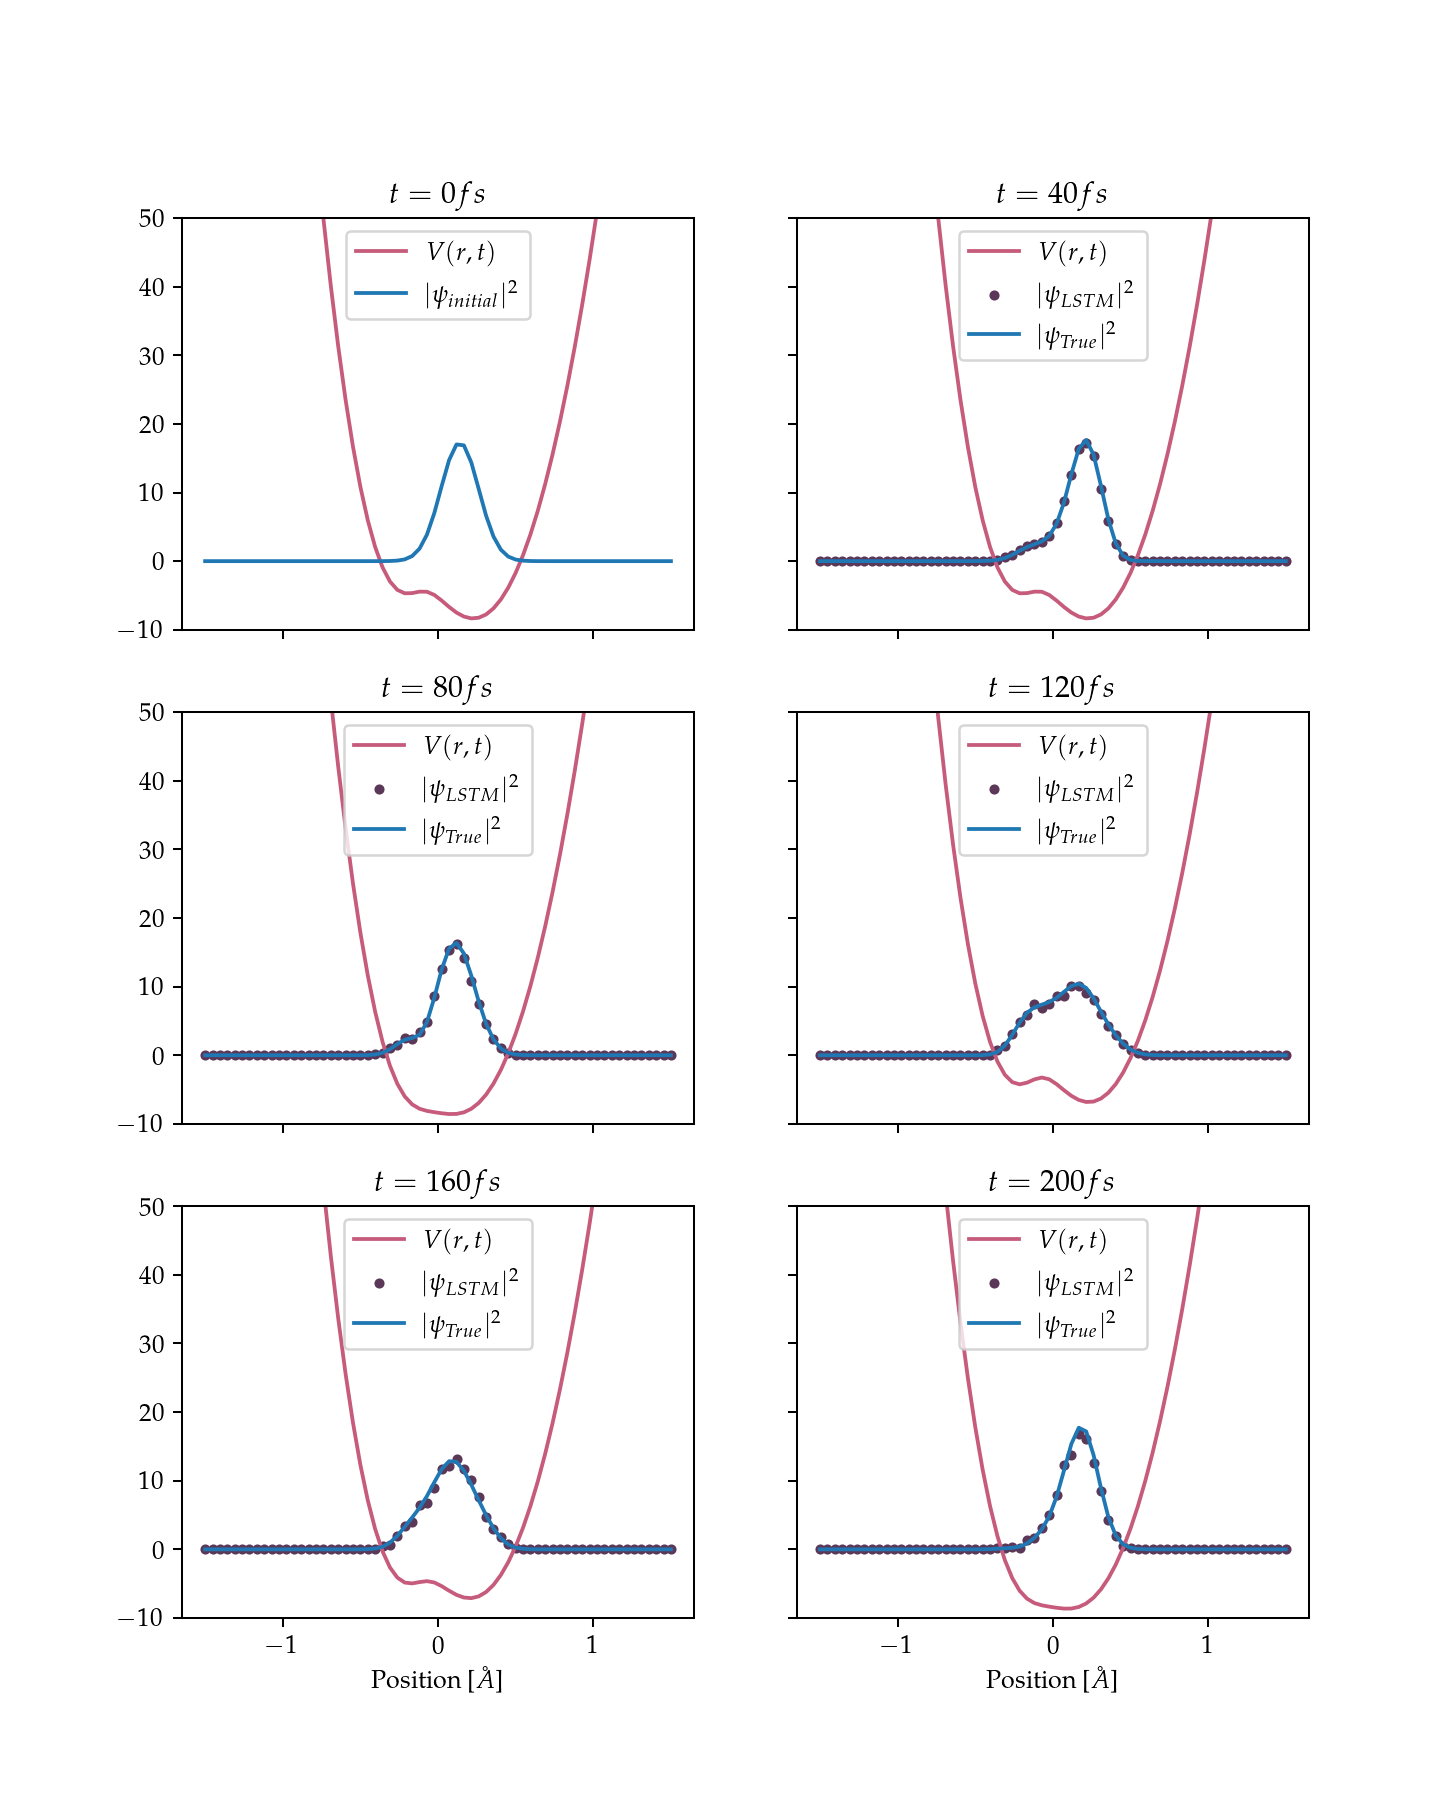

In [64]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax[0,0].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, In_dens0*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")



ax[0,1].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, Pred_dens0*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, Ou_dens0*10, label="$|\psi_{True}|^{2}$")
ax[0,1].set_title("$t=40 fs$")

ax[1,0].plot(r_n, Pote1*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, Pred_dens1*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, Ou_dens1*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=80 fs$")

ax[1,1].plot(r_n, Pote2*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, Pred_dens2*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, Ou_dens2*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=120 fs$")

ax[2,0].plot(r_n, Pote3*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, Pred_dens3*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, Ou_dens3*10, label="$|\psi_{True}|^{2}$")
ax[2,0].set_title("$t=160 fs$")

ax[2,1].plot(r_n, Pote4*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, Pred_dens4*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, Ou_dens4*10, label="$|\psi_{True}|^{2}$")
ax[2,1].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-10, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()
plt.savefig('/home/jessica/Tesis/img/tesis/model/trajDens64size.png', dpi=700)

In [33]:
with open(os.path.join('../Animacion/ModelLSTM-64size/prediccion.npy'), 'wb') as f:
    np.save(f, Prediccion)

In [34]:
with open(os.path.join('../Animacion/ModelLSTM-64size/salida.npy'), 'wb') as f:
    np.save(f, Salida)

In [35]:
Potencial = Entrada[:,128:192]

In [36]:
with open(os.path.join('../Animacion/ModelLSTM-64size/potencial.npy'), 'wb') as f:
    np.save(f, Potencial)